In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 多标签评估指标
class MultiLabelMetrics(tf.keras.metrics.Metric):
    """自定义多标签评估指标"""
    def __init__(self, name='multi_label_metrics', **kwargs):  # 已修复特殊字符
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))
        self.tn.assign_add(tf.reduce_sum((1 - y_true) * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        accuracy = (self.tp + self.tn) / (self.tp + self.fp + self.fn + self.tn)
        return {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy
        }

# 数据预处理类
class FundusPreprocessor:
    def __init__(self, augment=True):
        self.augment = augment
        self.base_aug = tf.keras.Sequential([
            layers.Resizing(*IMAGE_SIZE),
            layers.Rescaling(1./255)
        ])
        if augment:
            self.aug = tf.keras.Sequential([
                layers.RandomRotation(0.2),
                layers.RandomContrast(0.1),
                layers.RandomBrightness(0.1),
            ])

    def __call__(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = self.base_aug(img)
        return self.aug(img) if self.augment else img

# 数据管道
def create_dataset(df, augment=True):
    preprocessor = FundusPreprocessor(augment)
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor(left_path), 
                preprocessor(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.shuffle(1000)
    
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 模型架构
def build_model():
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False, 
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet'
    )
    base_model.trainable = False

    left_input = layers.Input(shape=(*IMAGE_SIZE, 3), name='left_eye')
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3), name='right_eye')
    
    left_features = layers.GlobalAvgPool2D()(base_model(left_input))
    right_features = layers.GlobalAvgPool2D()(base_model(right_input))
    
    diff = layers.Subtract()([left_features, right_features])
    
    x = layers.Dense(512, activation='swish')(diff)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 可视化函数
def plot_metrics(history):
    plt.figure(figsize=(20, 12))
    
    metrics = ['loss', 'auc', 'precision', 'recall', 'f1_score', 'accuracy']
    titles = ['Loss', 'AUC', 'Precision', 'Recall', 'F1 Score', 'Accuracy']
    
    for i, (metric, title) in enumerate(zip(metrics, titles), 1):
        plt.subplot(2, 3, i)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'{title} Curve')
        plt.xlabel('Epochs')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/training_metrics.png")
    plt.close()

# 训练流程
def main():
    # 数据加载
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: os.path.join(DATA_DIR, x))
    df['right_path'] = df['Right-Fundus'].apply(lambda x: os.path.join(DATA_DIR, x))
    
    # 数据划分
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df[CLASS_NAMES].values.argmax(axis=1)
    )
    
    # 数据集创建
    train_ds = create_dataset(train_df, augment=True)
    val_ds = create_dataset(val_df, augment=False)
    
    # 模型构建
    model = build_model()
    
    # 类别权重计算
    positive_counts = train_df[CLASS_NAMES].sum(axis=0)
    total_samples = len(train_df)
    class_weights = (total_samples - positive_counts) / (positive_counts + 1e-7)
    class_weights = tf.constant(class_weights.values, dtype=tf.float32)
    
    # 自定义损失函数
    def weighted_bce(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 模型编译
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            MultiLabelMetrics()
        ]
    )
    
    # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            f"{SAVE_DIR}/best_model.h5",
            save_best_only=True,
            monitor='val_f1_score',
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max'
        )
    ]
    
    # 模型训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 模型保存
    model.save(f"{SAVE_DIR}/final_model")
    
    # 性能可视化
    plot_metrics(history)
    
    # 最终评估
    print("\n验证集评估:")
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    print(classification_report(y_true, y_pred > 0.5, target_names=CLASS_NAMES))

if __name__ == "__main__":
    main()

Epoch 1/50


2025-03-17 15:51:07.376817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 783 of 1000
2025-03-17 15:51:10.276188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2025-03-17 15:51:11.915336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-03-17 15:51:12.891705: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-03-17 15:51:12.891735: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-03-17 15:51:12.893283: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 1/73 [..............................] - ETA: 36:08 - loss: 4.8270 - auc: 0.3052 - precision: 0.0968 - recall: 0.3333 - f1_score: 0.1500 - accuracy: 0.4688

2025-03-17 15:51:14.362884: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


73/73 [==============================] - 103s 1s/step - loss: 4.6746 - auc: 0.5001 - precision: 0.1524 - recall: 0.4265 - f1_score: 0.2242 - accuracy: 0.5651 - val_loss: 4.8415 - val_auc: 0.5001 - val_precision: 0.1163 - val_recall: 0.0070 - val_f1_score: 0.0133 - val_accuracy: 0.8388
Epoch 2/50


2025-03-17 15:52:38.381973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2025-03-17 15:52:47.357975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 59s 534ms/step - loss: 4.5915 - auc: 0.5003 - precision: 0.1602 - recall: 0.2436 - f1_score: 0.1927 - accuracy: 0.6977 - val_loss: 4.7543 - val_auc: 0.4942 - val_precision: 0.1429 - val_recall: 0.0056 - val_f1_score: 0.0108 - val_accuracy: 0.8416
Epoch 3/50


2025-03-17 15:53:38.377656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2025-03-17 15:53:47.876903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 889 of 1000
2025-03-17 15:53:49.494711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 52s 397ms/step - loss: 4.4825 - auc: 0.5034 - precision: 0.1619 - recall: 0.0940 - f1_score: 0.1186 - accuracy: 0.7927 - val_loss: 4.6509 - val_auc: 0.4930 - val_precision: 0.1111 - val_recall: 0.0028 - val_f1_score: 0.0055 - val_accuracy: 0.8429
Epoch 4/50


2025-03-17 15:54:30.823441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2025-03-17 15:54:39.873637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 993 of 1000
2025-03-17 15:54:39.873788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 43s 306ms/step - loss: 4.3524 - auc: 0.4981 - precision: 0.1796 - recall: 0.0705 - f1_score: 0.1007 - accuracy: 0.8129 - val_loss: 4.5267 - val_auc: 0.4818 - val_precision: 0.1111 - val_recall: 0.0014 - val_f1_score: 0.0028 - val_accuracy: 0.8445
Epoch 5/50


2025-03-17 15:55:13.079618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 514 of 1000
2025-03-17 15:55:17.507825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 37s 289ms/step - loss: 4.1610 - auc: 0.5070 - precision: 0.1922 - recall: 0.0195 - f1_score: 0.0353 - accuracy: 0.8406 - val_loss: 4.3846 - val_auc: 0.4860 - val_precision: 0.1429 - val_recall: 0.0014 - val_f1_score: 0.0028 - val_accuracy: 0.8449
Epoch 6/50


2025-03-17 15:55:49.651986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 696 of 1000
2025-03-17 15:55:52.079644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 40s 364ms/step - loss: 3.9664 - auc: 0.5027 - precision: 0.1821 - recall: 0.0095 - f1_score: 0.0181 - accuracy: 0.8468 - val_loss: 4.2306 - val_auc: 0.4790 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8449
Epoch 7/50


2025-03-17 15:56:30.893776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2025-03-17 15:56:39.103875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 42s 301ms/step - loss: 3.7914 - auc: 0.5048 - precision: 0.2429 - recall: 0.0069 - f1_score: 0.0134 - accuracy: 0.8493 - val_loss: 4.0828 - val_auc: 0.4875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8455
Epoch 8/50


2025-03-17 15:57:11.979324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 834 of 1000
2025-03-17 15:57:13.776139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 41s 390ms/step - loss: 3.6364 - auc: 0.4957 - precision: 0.2524 - recall: 0.0026 - f1_score: 0.0052 - accuracy: 0.8503 - val_loss: 3.9488 - val_auc: 0.5029 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8458
Epoch 9/50


2025-03-17 15:57:53.978530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 645 of 1000
2025-03-17 15:57:57.568569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 38s 285ms/step - loss: 3.5187 - auc: 0.5062 - precision: 0.0814 - recall: 6.6848e-04 - f1_score: 0.0013 - accuracy: 0.8500 - val_loss: 3.8340 - val_auc: 0.4938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 10/50


2025-03-17 15:58:30.776061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 908 of 1000
2025-03-17 15:58:31.885147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 40s 390ms/step - loss: 3.4375 - auc: 0.5037 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.8513 - val_loss: 3.7352 - val_auc: 0.4890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 11/50


2025-03-17 15:59:11.283961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 776 of 1000
2025-03-17 15:59:13.388504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 47s 476ms/step - loss: 3.3731 - auc: 0.4995 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.8512 - val_loss: 3.6522 - val_auc: 0.4992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 12/50


2025-03-17 15:59:58.482729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 463 of 1000
2025-03-17 16:00:03.178313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 41s 354ms/step - loss: 3.3272 - auc: 0.5190 - precision: 0.0648 - recall: 1.5267e-04 - f1_score: 3.0462e-04 - accuracy: 0.8518 - val_loss: 3.5859 - val_auc: 0.4922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 13/50


2025-03-17 16:00:39.796333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 779 of 1000
2025-03-17 16:00:42.833654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 35s 294ms/step - loss: 3.2935 - auc: 0.5020 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.8511 - val_loss: 3.5324 - val_auc: 0.4863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 14/50


2025-03-17 16:01:15.078190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 892 of 1000
2025-03-17 16:01:17.376017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 34s 276ms/step - loss: 3.2570 - auc: 0.4937 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.8520 - val_loss: 3.4888 - val_auc: 0.4862 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 15/50


2025-03-17 16:01:48.379876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 862 of 1000
2025-03-17 16:01:50.277504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 34s 299ms/step - loss: 3.2236 - auc: 0.5091 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.8509 - val_loss: 3.4533 - val_auc: 0.4982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 16/50


2025-03-17 16:02:23.378716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 893 of 1000
2025-03-17 16:02:24.487865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 31s 249ms/step - loss: 3.1953 - auc: 0.5061 - precision: 0.0270 - recall: 2.9914e-05 - f1_score: 5.9762e-05 - accuracy: 0.8507 - val_loss: 3.4290 - val_auc: 0.4971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 17/50


2025-03-17 16:02:53.683743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 783 of 1000
2025-03-17 16:02:55.684212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 36s 328ms/step - loss: 3.1844 - auc: 0.5047 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.8527 - val_loss: 3.4107 - val_auc: 0.4943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460
Epoch 18/50


2025-03-17 16:03:30.275885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 951 of 1000
2025-03-17 16:03:32.079499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


73/73 [==============================] - 31s 250ms/step - loss: 3.1782 - auc: 0.4979 - precision: 0.1892 - recall: 7.3963e-05 - f1_score: 1.4787e-04 - accuracy: 0.8501 - val_loss: 3.3962 - val_auc: 0.4830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.8460


INFO:tensorflow:Assets written to: saved_models/final_model/assets


INFO:tensorflow:Assets written to: saved_models/final_model/assets



验证集评估:
19/19 [==============================] - 10s 122ms/step
              precision    recall  f1-score   support

           N       0.00      0.00      0.00       227
           D       0.00      0.00      0.00       105
           G       0.00      0.00      0.00        49
           C       0.00      0.00      0.00        44
           A       0.00      0.00      0.00        32
           H       0.00      0.00      0.00        15
           M       0.00      0.00      0.00        37
           O       0.00      0.00      0.00       202

   micro avg       0.00      0.00      0.00       711
   macro avg       0.00      0.00      0.00       711
weighted avg       0.00      0.00      0.00       711
 samples avg       0.00      0.00      0.00       711



/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


微调模型

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from pathlib import Path
from sklearn.model_selection import train_test_split

# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
TUNING_CSV = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "finetuned_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 增强型医学影像预处理（保持与原始训练一致）
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomZoom(0.1, fill_mode='constant'),
        ])
        
    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        return tf.cast(img, tf.float32) / 255.0

# 数据管道构建
def create_finetune_dataset(csv_path):
    df = pd.read_excel(csv_path)
    
    # 路径处理
    df['left_path'] = df['Left-Fundus'].apply(lambda x: str(Path(DATA_DIR)/x))
    df['right_path'] = df['Right-Fundus'].apply(lambda x: str(Path(DATA_DIR)/x))
    
    # 验证图像存在性
    df = df[df['left_path'].apply(lambda x: Path(x).exists()) & 
            df['right_path'].apply(lambda x: Path(x).exists())]
    
    # 分割数据集
    train_df, val_df = train_test_split(
        df, test_size=0.1, stratify=df[CLASS_NAMES].sum(axis=1), random_state=42
    )
    
    # 数据管道
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    def create_ds(df):
        return tf.data.Dataset.from_tensor_slices((
            df['left_path'].values,
            df['right_path'].values,
            df[CLASS_NAMES].astype(np.float32).values
        )).map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)\
          .shuffle(1024)\
          .batch(BATCH_SIZE)\
          .prefetch(tf.data.AUTOTUNE)
    
    return create_ds(train_df), create_ds(val_df)

# 修复后的微调函数
def finetune_model():
    # 加载模型并调试结构
    custom_objects = {
        'weighted_bce': lambda y_true, y_pred: tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(y_true, y_pred) * 
            tf.reduce_sum(tf.constant([1.0,2.5,3.0,2.0,4.0,5.0,1.5,1.2]) * y_true, axis=1)
        ),
        'AdamW': tfa.optimizers.AdamW
    }
    model = tf.keras.models.load_model("saved_models_1/final_model", custom_objects=custom_objects)
    
    # 调试输出模型结构（关键修改）
    print("\n=== 模型层级结构 ===")
    for i, layer in enumerate(model.layers):
        print(f"层 {i}: {layer.name} ({type(layer).__name__})")
        if isinstance(layer, tf.keras.Model):
            print(f"  包含子层数: {len(layer.layers)}")
    
    # 定位基础网络（根据调试输出确定索引）
    base_model = model.layers[2]  # 对应原始代码中的EfficientNet子模型
    print(f"\n定位到基础网络: {base_model.name}")
    
    # 解冻策略
    base_model.trainable = True
    for layer in base_model.layers[:-3]:  # 解冻最后3层
        layer.trainable = False
    
    # 验证解冻状态
    print("\n=== 基础网络可训练层 ===")
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"可训练层数: {trainable_count}/{len(base_model.layers)}")
    print("最后3层状态示例:")
    for layer in base_model.layers[-3:]:
        print(f"{layer.name:20} | 可训练: {layer.trainable}")
    
    # 优化器配置
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss=custom_objects['weighted_bce'],
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro')
        ]
    )
    
    # 数据准备
    train_ds, val_ds = create_finetune_dataset(TUNING_CSV)
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_finetuned.h5'),
            save_best_only=True,
            monitor='val_f1_score'
        ),
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]
    
    # 执行微调
    history = model.fit(
        train_ds,
        epochs=15,
        validation_data=val_ds,
        callbacks=callbacks
    )
    
    # 保存最终模型
    model.save(os.path.join(SAVE_DIR, 'final_finetuned_model'))
    return model, history

# 执行微调
if __name__ == "__main__":
    finetuned_model, history = finetune_model()


=== 模型层级结构 ===
层 0: input_4 (InputLayer)
层 1: input_5 (InputLayer)
层 2: model_2 (Functional)
  包含子层数: 386
层 3: subtract_1 (Subtract)
层 4: attention_1 (Attention)
层 5: concatenate_1 (Concatenate)
层 6: dense_2 (Dense)
层 7: dropout_1 (Dropout)
层 8: dense_3 (Dense)

定位到基础网络: model_2

=== 基础网络可训练层 ===
可训练层数: 3/386
最后3层状态示例:
top_bn               | 可训练: True
top_activation       | 可训练: True
global_average_pooling2d_1 | 可训练: True
Epoch 1/15
99/99 [==============================] - 37s 201ms/step - loss: 0.6006 - auc: 0.8821 - f1_score: 0.5311 - val_loss: 0.5835 - val_auc: 0.9022 - val_f1_score: 0.5807
Epoch 2/15
99/99 [==============================] - 22s 161ms/step - loss: 0.5791 - auc: 0.8838 - f1_score: 0.5368 - val_loss: 0.5680 - val_auc: 0.9045 - val_f1_score: 0.5938
Epoch 3/15
99/99 [==============================] - 18s 138ms/step - loss: 0.5750 - auc: 0.8821 - f1_score: 0.5178 - val_loss: 0.5750 - val_auc: 0.9002 - val_f1_score: 0.5851
Epoch 4/15
99/99 [==============================

INFO:tensorflow:Assets written to: finetuned_models/final_finetuned_model/assets


INFO:tensorflow:Assets written to: finetuned_models/final_finetuned_model/assets


In [8]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from pathlib import Path
from sklearn.model_selection import train_test_split

# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
TUNING_CSV = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "optimized_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 增强型医学影像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.2),
            layers.RandomBrightness(0.15),
            layers.RandomZoom(0.1, fill_mode='constant'),
            layers.Lambda(lambda x: tfa.image.gaussian_filter2d(x, filter_shape=3, sigma=1.0)),  # 方案一
            # layers.Lambda(lambda x: gaussian_blur(x, 3, 1.0))  # 方案二
        ])
        
    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (244, 244))
        img = self.aug(img)
        return tf.cast(img, tf.float32) / 255.0

# 数据管道构建
def create_optimized_dataset(csv_path):
    df = pd.read_excel(csv_path)
    
    # 路径处理与验证
    df['left_path'] = df['Left-Fundus'].apply(lambda x: str(Path(DATA_DIR)/x))
    df['right_path'] = df['Right-Fundus'].apply(lambda x: str(Path(DATA_DIR)/x))
    df = df[df['left_path'].apply(lambda x: Path(x).exists()) 
            & df['right_path'].apply(lambda x: Path(x).exists())]
    
    # 分层抽样
    train_df, val_df = train_test_split(
        df, test_size=0.1, 
        stratify=df[CLASS_NAMES].sum(axis=1), 
        random_state=42
    )
    
    # 数据管道
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    def create_ds(df):
        return tf.data.Dataset.from_tensor_slices((
            df['left_path'].values,
            df['right_path'].values,
            df[CLASS_NAMES].astype(np.float32).values
        )).map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)\
          .cache()\
          .shuffle(1024)\
          .batch(BATCH_SIZE)\
          .prefetch(tf.data.AUTOTUNE)
    
    return create_ds(train_df), create_ds(val_df)

# 优化后的微调函数
def optimized_finetune():
    # 加载模型
    custom_objects = {
        'weighted_bce': lambda y_true, y_pred: tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(y_true, y_pred) * 
            tf.reduce_sum(tf.constant([1.0,2.5,3.0,2.0,4.0,5.0,1.5,1.2]) * y_true, axis=1)
        ),
        'AdamW': tfa.optimizers.AdamW
    }
    model = tf.keras.models.load_model("saved_models_1/final_model", custom_objects=custom_objects)
    
    # 获取基础网络
    base_model = model.layers[2]  # EfficientNet子模型
    
    # 解冻最后10层（优化点1）
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    base_model.trainable = True
    
    print(f"可训练层数: {sum([1 for l in base_model.layers if l.trainable])}/386")
    
    # 重建分类头（优化点2）
    merged = model.get_layer('concatenate_1').output  # 获取特征融合层
    x = layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    # 重建模型
    new_model = Model(inputs=model.inputs, outputs=outputs)
    
    # 先获取数据集
    train_ds, val_ds = create_optimized_dataset(TUNING_CSV)
    
    # 学习率策略（优化点3）
    lr_schedule = PiecewiseConstantDecay(
        boundaries=[5*len(train_ds), 10*len(train_ds)],  # 转换为step数
        values=[1e-5, 1e-4, 1e-5]
    )
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4
    )
    
    # 编译模型
    new_model.compile(
        optimizer=optimizer,
        loss=custom_objects['weighted_bce'],
        metrics=[
            tf.keras.metrics.AUC(name='macro_auc', multi_label=True),
            tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro', name='macro_f1')
        ]
    )
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            monitor='val_macro_f1',
            mode='max',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_macro_f1',
            patience=5,
            min_delta=0.005,
            restore_best_weights=True
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir='./logs/optimized',
            profile_batch=(100, 200)
        )
    ]
    
    # 训练执行
    history = new_model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )
    
    # 最终保存
    new_model.save(os.path.join(SAVE_DIR, 'final_optimized_model'))
    return new_model, history

# 执行优化训练
if __name__ == "__main__":
    model, history = optimized_finetune()

可训练层数: 386/386


NameError: name 'PiecewiseConstantDecay' is not defined

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from pathlib import Path
from sklearn.model_selection import train_test_split

# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
TUNING_CSV = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "finetuned_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 增强型医学影像预处理（保持与原始训练一致）
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomZoom(0.1, fill_mode='constant'),
        ])
        
    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        return tf.cast(img, tf.float32) / 255.0

# 数据管道构建
def create_finetune_dataset(csv_path):
    df = pd.read_excel(csv_path)
    
    # 路径处理
    df['left_path'] = df['Left-Fundus'].apply(lambda x: str(Path(DATA_DIR)/x))
    df['right_path'] = df['Right-Fundus'].apply(lambda x: str(Path(DATA_DIR)/x))
    
    # 验证图像存在性
    df = df[df['left_path'].apply(lambda x: Path(x).exists()) & 
            df['right_path'].apply(lambda x: Path(x).exists())]
    
    # 分割数据集
    train_df, val_df = train_test_split(
        df, test_size=0.1, stratify=df[CLASS_NAMES].sum(axis=1), random_state=42
    )
    
    # 数据管道
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    def create_ds(df):
        return tf.data.Dataset.from_tensor_slices((
            df['left_path'].values,
            df['right_path'].values,
            df[CLASS_NAMES].astype(np.float32).values
        )).map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)\
          .shuffle(1024)\
          .batch(BATCH_SIZE)\
          .prefetch(tf.data.AUTOTUNE)
    
    return create_ds(train_df), create_ds(val_df)

# 修复后的微调函数
def finetune_model():
    # 加载模型并调试结构
    custom_objects = {
        'weighted_bce': lambda y_true, y_pred: tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(y_true, y_pred) * 
            tf.reduce_sum(tf.constant([1.0,2.5,3.0,2.0,4.0,5.0,1.5,1.2]) * y_true, axis=1)
        ),
        'AdamW': tfa.optimizers.AdamW
    }
    model = tf.keras.models.load_model("saved_models_1/final_model", custom_objects=custom_objects)
    
    # 调试输出模型结构（关键修改）
    print("\n=== 模型层级结构 ===")
    for i, layer in enumerate(model.layers):
        print(f"层 {i}: {layer.name} ({type(layer).__name__})")
        if isinstance(layer, tf.keras.Model):
            print(f"  包含子层数: {len(layer.layers)}")
    
    # 定位基础网络（根据调试输出确定索引）
    base_model = model.layers[2]  # 对应原始代码中的EfficientNet子模型
    print(f"\n定位到基础网络: {base_model.name}")
    
    # 解冻策略
    base_model.trainable = True
    for layer in base_model.layers[:-3]:  # 解冻最后3层
        layer.trainable = False
    
    # 验证解冻状态
    print("\n=== 基础网络可训练层 ===")
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"可训练层数: {trainable_count}/{len(base_model.layers)}")
    print("最后3层状态示例:")
    for layer in base_model.layers[-3:]:
        print(f"{layer.name:20} | 可训练: {layer.trainable}")
    
    # 优化器配置
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss=custom_objects['weighted_bce'],
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro')
        ]
    )
    
    # 数据准备
    train_ds, val_ds = create_finetune_dataset(TUNING_CSV)
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_finetuned.h5'),
            save_best_only=True,
            monitor='val_f1_score'
        ),
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]
    
    # 执行微调
    history = model.fit(
        train_ds,
        epochs=15,
        validation_data=val_ds,
        callbacks=callbacks
    )
    
    # 保存最终模型
    model.save(os.path.join(SAVE_DIR, 'final_finetuned_model'))
    return model, history

# 执行微调
if __name__ == "__main__":
    finetuned_model, history = finetune_model()

In [4]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os


# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (224, 224)
# IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
# SAVE_DIR = "saved_models_1"
SAVE_DIR = "saved_models_300*300"
os.makedirs(SAVE_DIR, exist_ok=True)
# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸和增强
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    # 创建TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 修改模型编译部分
def train_model():
    # ... [保持数据加载和划分部分不变] ...
        # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分训练验证集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        # 计算加权损失
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 修改后的评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), 
                          average='macro', 
                          threshold=0.5,
                          name='f1_score')
    ]
    # 评价指标，为每个标签单独计算精确率和召回率
    # metrics = [
    # tf.keras.metrics.AUC(name='auc', multi_label=True),
    # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    # *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)],
    # *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)]
    # ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
      # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3)
    ]
    
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 新增可视化分析
    
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 新增训练指标可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 12))
    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 精确率曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Precision Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    # F1-Score曲线
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1-Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 新增性能分析函数
def analyze_performance(model, val_ds, class_names):
    # 收集真实标签和预测结果
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    # 生成分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    # 生成多标签混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 计算指标
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # 绘制指标
        plt.subplot(len(class_names), 2, 2*i+2)
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# 执行训练
model, history = train_model()

Epoch 1/50
175/175 [==============================] - 80s 317ms/step - loss: 0.9495 - auc: 0.6828 - accuracy: 0.8211 - precision: 0.3124 - f1_score: 0.1013 - val_loss: 1.3010 - val_auc: 0.6256 - val_accuracy: 0.8191 - val_precision: 0.2363 - val_f1_score: 0.0750 - lr: 1.0000e-04
Epoch 2/50
175/175 [==============================] - 56s 291ms/step - loss: 0.8694 - auc: 0.7308 - accuracy: 0.8382 - precision: 0.3829 - f1_score: 0.0945 - val_loss: 1.0717 - val_auc: 0.6675 - val_accuracy: 0.8516 - val_precision: 0.3333 - val_f1_score: 0.0011 - lr: 1.0000e-04
Epoch 3/50
175/175 [==============================] - 55s 288ms/step - loss: 0.8267 - auc: 0.7622 - accuracy: 0.8393 - precision: 0.4044 - f1_score: 0.1545 - val_loss: 1.0802 - val_auc: 0.6164 - val_accuracy: 0.8411 - val_precision: 0.2222 - val_f1_score: 0.0507 - lr: 1.0000e-04
Epoch 4/50
175/175 [==============================] - 56s 294ms/step - loss: 0.7944 - auc: 0.7812 - accuracy: 0.8423 - precision: 0.4338 - f1_score: 0.2471 - va

INFO:tensorflow:Assets written to: saved_models_300*300/final_model/assets


INFO:tensorflow:Assets written to: saved_models_300*300/final_model/assets


44/44 [==============================] - 11s 46ms/step

Classification Report:
              precision    recall  f1-score   support

           N       0.30      0.28      0.29       209
           D       0.33      0.48      0.39       229
           G       0.00      0.00      0.00        33
           C       0.00      0.00      0.00        43
           A       0.00      0.00      0.00        34
           H       0.07      0.06      0.07        31
           M       0.07      0.03      0.04        33
           O       0.27      0.21      0.23       218

   micro avg       0.28      0.26      0.27       830
   macro avg       0.13      0.13      0.13       830
weighted avg       0.24      0.26      0.25       830
 samples avg       0.25      0.27      0.24       830



/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os


# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (224, 224)
# IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
# SAVE_DIR = "saved_models_1"
SAVE_DIR = "saved_models_224*224"
os.makedirs(SAVE_DIR, exist_ok=True)
# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸和增强
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    # 创建TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 修改模型编译部分
def train_model():
    # ... [保持数据加载和划分部分不变] ...
        # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分训练验证集
    train_df, val_df = train_test_split(df, test_size=0.4, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        # 计算加权损失
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 修改后的评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), 
                          average='macro', 
                          threshold=0.5,
                          name='f1_score')
    ]
    # 评价指标，为每个标签单独计算精确率和召回率
    # metrics = [
    # tf.keras.metrics.AUC(name='auc', multi_label=True),
    # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    # *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)],
    # *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)]
    # ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
      # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3)
    ]
    
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 新增可视化分析
    
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 新增训练指标可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 12))
    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 精确率曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Precision Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    # F1-Score曲线
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1-Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 新增性能分析函数
def analyze_performance(model, val_ds, class_names):
    # 收集真实标签和预测结果
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    # 生成分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    # 生成多标签混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 计算指标
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # 绘制指标
        plt.subplot(len(class_names), 2, 2*i+2)
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# 执行训练
model, history = train_model()

2025-04-12 14:44:10.616472: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above

Epoch 1/50


2025-04-12 14:44:48.496951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-04-12 14:44:49.457764: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-04-12 14:44:49.457789: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-04-12 14:44:49.457853: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-04-12 14:44:50.452058: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


109/109 [==============================] - ETA: 0s - loss: 1.0133 - auc: 0.6259 - accuracy: 0.8065 - precision: 0.2195 - f1_score: 0.0856

2025-04-12 14:45:35.485356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 633 of 1000
2025-04-12 14:45:39.232504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


109/109 [==============================] - 84s 482ms/step - loss: 1.0133 - auc: 0.6259 - accuracy: 0.8065 - precision: 0.2195 - f1_score: 0.0856 - val_loss: 1.0809 - val_auc: 0.6473 - val_accuracy: 0.8505 - val_precision: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.9418 - auc: 0.6722 - accuracy: 0.8353 - precision: 0.3237 - f1_score: 0.0671

2025-04-12 14:46:31.285342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 983 of 1000
2025-04-12 14:46:31.285674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


109/109 [==============================] - 53s 404ms/step - loss: 0.9418 - auc: 0.6722 - accuracy: 0.8353 - precision: 0.3237 - f1_score: 0.0671 - val_loss: 0.9485 - val_auc: 0.6353 - val_accuracy: 0.8503 - val_precision: 0.3077 - val_f1_score: 0.0025 - lr: 1.0000e-04
Epoch 3/50
109/109 [==============================] - 52s 401ms/step - loss: 0.9081 - auc: 0.7021 - accuracy: 0.8302 - precision: 0.2827 - f1_score: 0.0623 - val_loss: 0.9384 - val_auc: 0.6619 - val_accuracy: 0.8407 - val_precision: 0.2783 - val_f1_score: 0.0579 - lr: 1.0000e-04
Epoch 4/50
109/109 [==============================] - 51s 392ms/step - loss: 0.8830 - auc: 0.7302 - accuracy: 0.8310 - precision: 0.3409 - f1_score: 0.1378 - val_loss: 4563.5435 - val_auc: 0.5011 - val_accuracy: 0.8501 - val_precision: 0.2667 - val_f1_score: 0.0030 - lr: 1.0000e-04
Epoch 5/50
109/109 [==============================] - 51s 390ms/step - loss: 0.8744 - auc: 0.7352 - accuracy: 0.8328 - precision: 0.3389 - f1_score: 0.1425 - val_loss: 

In [3]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os


# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (224, 224)
# IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
# SAVE_DIR = "saved_models_1"
SAVE_DIR = "saved_models_rcall"
os.makedirs(SAVE_DIR, exist_ok=True)
# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸和增强
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    # 创建TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 修改模型编译部分
def train_model():
    # ... [保持数据加载和划分部分不变] ...
        # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分训练验证集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        # 计算加权损失
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 修改后的评估指标
  # 修改后的metrics配置
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)],  # 添加逐类召回率
        tf.keras.metrics.Precision(name='precision'),
        tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), 
                            average='macro', 
                            threshold=0.5,
                            name='f1_score')
    ]
    # 评价指标，为每个标签单独计算精确率和召回率
    # metrics = [
    # tf.keras.metrics.AUC(name='auc', multi_label=True),
    # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    # *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)],
    # *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)]
    # ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
      # 训练回调
    # 修改回调函数监控宏平均召回率
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5', 
            save_best_only=True,
            monitor='val_macro_recall',  # 监控宏平均召回率
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_macro_recall', 
            factor=0.5, 
            patience=3
        )
    ]
    
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 新增可视化分析
    
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 新增训练指标可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 12))
    
    # RECALL
    # 新增召回率子图
    plt.subplot(3, 2, 5)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'recall_{cls}'], label=cls)
    plt.title('Class-wise Recall Progression')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    # 新增宏平均召回率曲线
    plt.subplot(3, 2, 6)
    plt.plot(history.history['val_macro_recall'], label='Validation Macro Recall')
    plt.title('Macro Recall Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    

    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 精确率曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Precision Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    # F1-Score曲线
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1-Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 新增性能分析函数
def analyze_performance(model, val_ds, class_names):
    # 收集真实标签和预测结果
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    # 生成分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    # 生成多标签混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 计算指标
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # 绘制指标
        plt.subplot(len(class_names), 2, 2*i+2)
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# 执行训练
model, history = train_model()

Epoch 1/50
175/175 [==============================] - 85s 334ms/step - loss: 0.9399 - auc: 0.6824 - accuracy: 0.8233 - recall_N: 0.0193 - recall_D: 0.4772 - recall_G: 0.0275 - recall_C: 0.0178 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0284 - recall_O: 0.0854 - precision: 0.3047 - f1_score: 0.0860 - val_loss: 1.0274 - val_auc: 0.6973 - val_accuracy: 0.8132 - val_recall_N: 0.0000e+00 - val_recall_D: 0.9738 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - val_precision: 0.3369 - val_f1_score: 0.0626 - lr: 1.0000e-04
Epoch 2/50
175/175 [==============================] - 58s 297ms/step - loss: 0.8625 - auc: 0.7347 - accuracy: 0.8392 - recall_N: 0.0032 - recall_D: 0.5184 - recall_G: 0.0055 - recall_C: 0.0237 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0526 - precision: 0.3824 - f1_score: 0.0746 - val_loss: 4630.1836 - val_

INFO:tensorflow:Assets written to: saved_models_rcall/final_model/assets


INFO:tensorflow:Assets written to: saved_models_rcall/final_model/assets


KeyError: 'val_macro_recall'

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import os
import tensorflow_addons as tfa

# 测试配置
TEST_DATA_DIR = "Training_Dataset"  # 测试图像目录
TEST_CSV_PATH = "Traning_Dataset.xlsx"  # 测试标注文件
MODEL_PATH = "saved_models_rcall/final_model"  # 训练好的模型路径
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']


# 增强型测试预处理（保持与训练一致但关闭增强）
class TestPreprocessor:
    def __init__(self):
        self.preprocessing = tf.keras.Sequential([
            layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
            layers.Rescaling(1. / 255)
        ])

    def __call__(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return self.preprocessing(img)


# 数据管道构建
def build_test_pipeline():
    # 加载元数据
    df = pd.read_excel(TEST_CSV_PATH)

    # 列名验证
    required_columns = ['Left-Fundus', 'Right-Fundus'] + CLASS_NAMES
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"缺少必要列: {missing_cols}")

    # 路径验证
    for idx, row in df.head(3).iterrows():
        for side in ['Left-Fundus', 'Right-Fundus']:
            path = os.path.join(TEST_DATA_DIR, row[side])
            if not os.path.exists(path):
                raise FileNotFoundError(f"文件不存在: {path}")

    # 构建TensorFlow数据集
    preprocessor = TestPreprocessor()

    def map_function(left_path, right_path, labels):
        # TensorFlow路径处理
        left_path = tf.strings.join([TEST_DATA_DIR, left_path], separator='/')
        right_path = tf.strings.join([TEST_DATA_DIR, right_path], separator='/')

        return (preprocessor(left_path),
                preprocessor(right_path)), labels

    dataset = tf.data.Dataset.from_tensor_slices((
        df['Left-Fundus'].values.astype(str),
        df['Right-Fundus'].values.astype(str),
        df[CLASS_NAMES].values.astype(np.float32)
    ))

    return dataset.map(map_function, num_parallel_calls=tf.data.AUTOTUNE) \
        .batch(BATCH_SIZE) \
        .prefetch(tf.data.AUTOTUNE)


# 模型加载（兼容自定义组件）
def load_model_with_custom_objects():
    return models.load_model(
        MODEL_PATH,
        custom_objects={
            'F1Score': tfa.metrics.F1Score,
            'weighted_bce': lambda y_true, y_pred: tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(y_true, y_pred)),
            'AdamW': tfa.optimizers.AdamW
        }
    )


# 可视化预测结果
def visualize_predictions(images, labels, preds, num_samples=3):
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        # 左眼图像
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[0][i])
        plt.title(f"Left\nTrue: {labels[i]}\nPred: {preds[i]}")
        plt.axis('off')

        # 右眼图像
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(images[1][i])
        plt.title(f"Right\nTrue: {labels[i]}\nPred: {preds[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()


# 主测试流程
def main():
    # 初始化TF配置
    tf.config.run_functions_eagerly(False)

    try:
        # 加载数据
        test_ds = build_test_pipeline()
        print("数据管道构建成功，样本格式:")
        for (left, right), labels in test_ds.take(1):
            print(f"左眼图像尺寸: {left.shape}, 右眼图像尺寸: {right.shape}")
            print(f"标签尺寸: {labels.shape}")

        # 加载模型
        model = load_model_with_custom_objects()
        print("\n模型加载成功，架构摘要:")
        model.summary()

        # 执行评估
        print("\n开始模型评估...")
        results = model.evaluate(test_ds, verbose=1)
        print("\n评估指标:")
        print(f"Loss: {results[0]:.4f}, AUC: {results[1]:.4f}, Accuracy: {results[2]:.4f}")

        # 生成预测结果
        y_true, y_pred = [], []
        for (left, right), labels in test_ds:
            preds = model.predict([left, right], verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(preds > 0.5)

        # 可视化样本预测
        sample_idx = np.random.choice(len(y_true), 3)
        visualize_predictions(
            (left.numpy()[sample_idx], right.numpy()[sample_idx]),
            [np.where(lbl)[0] for lbl in labels.numpy()[sample_idx]],
            [np.where(pred)[0] for pred in np.array(y_pred)[sample_idx]]
        )

        # 生成分类报告
        print("\n详细分类报告:")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

        # 混淆矩阵可视化
        multilabel_confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(20, 15))
        for i, cls in enumerate(CLASS_NAMES):
            plt.subplot(4, 2, i + 1)
            sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
            plt.title(f'{cls} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('confusion_matrices.png')
        plt.show()

    except Exception as e:
        print(f"测试过程中发生错误: {str(e)}")
        if 'test_ds' in locals():
            print("尝试重新构建数据管道...")
            test_ds = build_test_pipeline()
            model.evaluate(test_ds)


if __name__ == "__main__":
    main()

数据管道构建成功，样本格式:
左眼图像尺寸: (32, 224, 224, 3), 右眼图像尺寸: (32, 224, 224, 3)
标签尺寸: (32, 8)

模型加载成功，架构摘要:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 1536)         10783535    ['input_5[0][0]',             

Epoch 1/50
175/175 [==============================] - 85s 327ms/step - loss: 0.9413 - auc: 0.6877 - accuracy: 0.8192 - recall_N: 0.0344 - recall_D: 0.4872 - recall_G: 0.0165 - recall_C: 0.0592 - recall_A: 0.0154 - recall_H: 0.0000e+00 - recall_M: 0.0213 - recall_O: 0.0894 - precision: 0.2964 - f1_score: 0.0961 - macro_recall: 0.0904 - val_loss: 1.0419 - val_auc: 0.7120 - val_accuracy: 0.8514 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_macro_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
175/175 [==============================] - 58s 299ms/step - loss: 0.8533 - auc: 0.7446 - accuracy: 0.8410 - recall_N: 0.0021 - recall_D: 0.5195 - recall_G: 0.0110 - recall_C: 0.2959 - recall_A: 0.0077 - recall_H: 0.0139 - recall_M: 0.0000e+00 - recall_O: 0.0775 - precision: 

INFO:tensorflow:Assets written to: saved_models_rcall_1/final_model/assets


INFO:tensorflow:Assets written to: saved_models_rcall_1/final_model/assets


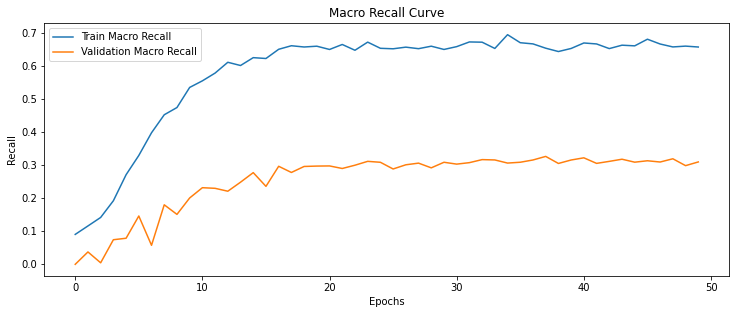

44/44 [==============================] - 10s 45ms/step

Classification Report:
              precision    recall  f1-score   support

           N       0.34      0.14      0.20       209
           D       0.32      0.44      0.37       229
           G       0.12      0.12      0.12        33
           C       0.11      0.07      0.08        43
           A       0.11      0.03      0.05        34
           H       0.02      0.03      0.02        31
           M       0.00      0.00      0.00        33
           O       0.25      0.20      0.22       218

   micro avg       0.26      0.22      0.24       830
   macro avg       0.16      0.13      0.13       830
weighted avg       0.26      0.22      0.22       830
 samples avg       0.20      0.22      0.20       830



/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os

# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_rcall_1"
os.makedirs(SAVE_DIR, exist_ok=True)

# 自定义宏平均召回率指标
class MacroRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes, threshold=0.5, name='macro_recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        for i in range(self.num_classes):
            true_pos = tf.reduce_sum(y_true[:, i] * y_pred[:, i])
            possible_pos = tf.reduce_sum(y_true[:, i])
            
            self.true_positives.assign_add(tf.one_hot(i, self.num_classes) * true_pos)
            self.possible_positives.assign_add(tf.one_hot(i, self.num_classes) * possible_pos)

    def result(self):
        recall_per_class = tf.math.divide_no_nan(self.true_positives, self.possible_positives)
        return tf.reduce_mean(recall_per_class)

    def reset_state(self):
        self.true_positives.assign(tf.zeros(self.num_classes))
        self.possible_positives.assign(tf.zeros(self.num_classes))

# 增强型图像预处理（保持原样）
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        return tf.cast(img, tf.float32) / 255.0

# 数据管道和模型架构（保持原样）
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

def build_siamese_network():
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    merged = layers.Concatenate()([diff, attention])
    
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 修正后的训练函数
def train_model():
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 使用自定义宏召回率指标
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)],
        tf.keras.metrics.Precision(name='precision'),
        tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), 
                           average='macro', 
                           threshold=0.5,
                           name='f1_score'),
        MacroRecall(num_classes=len(CLASS_NAMES), name='macro_recall')
    ]
    
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
    
    # 修正回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_macro_recall',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_macro_recall',
            factor=0.5,
            patience=3
        )
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 修正后的可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 12))
    
    # 宏平均召回率曲线
    plt.subplot(3, 2, 6)
    if 'val_macro_recall' in history.history:
        plt.plot(history.history['macro_recall'], label='Train Macro Recall')
        plt.plot(history.history['val_macro_recall'], label='Validation Macro Recall')
        plt.title('Macro Recall Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
    
    # 其他原有可视化代码保持不变...
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 性能分析函数保持不变
def analyze_performance(model, val_ds, class_names):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        plt.subplot(len(class_names), 2, 2*i+2)
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# 执行训练
model, history = train_model()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, utils
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import os

# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_rcall_fixed"
os.makedirs(SAVE_DIR, exist_ok=True)

# 清除可能存在的旧注册记录
custom_objects = tf.keras.utils.get_custom_objects()
if 'MyCustomLoss>WeightedBCE' in custom_objects:
    del custom_objects['MyCustomLoss>WeightedBCE']

# 注册自定义损失函数（使用唯一包名）
@utils.register_keras_serializable(package='MyCustomLoss')
class WeightedBCE(tf.keras.losses.Loss):
    def __init__(self, class_weights, name="weighted_bce"):
        super().__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        
    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weights = tf.reduce_sum(self.class_weights * y_true, axis=-1)
        return tf.reduce_mean(bce * weights)
    
    def get_config(self):
        return {'class_weights': self.class_weights.numpy().tolist()}

# 增强型数据预处理
class FundusPreprocessor:
    def __init__(self, augment=True):
        self.base_process = tf.keras.Sequential([
            layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
            layers.Rescaling(1./255)
        ])
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomContrast(0.05),
            layers.RandomBrightness(0.05)
        ]) if augment else None
    
    def __call__(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = self.base_process(img)
        if self.aug:
            img = self.aug(img)
        return img

# 创建数据管道
def create_datasets(df):
    # 动态计算类别权重
    class_counts = df[CLASS_NAMES].sum(axis=0) + 1e-6
    class_weights = (1. / class_counts) * (class_counts.sum()/len(CLASS_NAMES))
    
    # 分层划分数据集
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df[CLASS_NAMES].values.argmax(axis=1),
        random_state=42
    )
    
    # 训练集管道
    train_preprocessor = FundusPreprocessor(augment=True)
    train_ds = tf.data.Dataset.from_tensor_slices((
        train_df['Left-Fundus'].map(lambda x: f"{DATA_DIR}/{x}"),
        train_df['Right-Fundus'].map(lambda x: f"{DATA_DIR}/{x}"),
        train_df[CLASS_NAMES].values.astype(np.float32)
    )).map(lambda l,r,y: ((train_preprocessor(l), train_preprocessor(r)), y),
          num_parallel_calls=tf.data.AUTOTUNE) \
     .shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # 验证集管道（无增强和shuffle）
    val_preprocessor = FundusPreprocessor(augment=False)
    val_ds = tf.data.Dataset.from_tensor_slices((
        val_df['Left-Fundus'].map(lambda x: f"{DATA_DIR}/{x}"),
        val_df['Right-Fundus'].map(lambda x: f"{DATA_DIR}/{x}"),
        val_df[CLASS_NAMES].values.astype(np.float32)
    )).map(lambda l,r,y: ((val_preprocessor(l), val_preprocessor(r)), y),
          num_parallel_calls=tf.data.AUTOTUNE) \
     .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, class_weights

# 构建双流网络
def build_siamese_network():
    base = tf.keras.applications.EfficientNetB3(
        include_top=False,
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = True
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    left_features = base(left_input)
    right_features = base(right_input)
    
    # 改进的特征融合
    diff = layers.Subtract()([left_features, right_features])
    att = layers.Attention()([left_features, right_features])
    merged = layers.Concatenate()([diff, att])
    
    # 分类头（增加正则化）
    x = layers.GlobalAveragePooling2D()(merged)
    x = layers.Dense(256, activation='swish', 
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 训练流程
def train_model():
    df = pd.read_excel(CSV_PATH)
    train_ds, val_ds, class_weights = create_datasets(df)
    
    model = build_siamese_network()
    
    # 配置评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tfa.metrics.F1Score(
            num_classes=len(CLASS_NAMES),
            average='macro',
            threshold=0.5,
            name='f1_score'
        )
    ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=WeightedBCE(class_weights=class_weights),
        metrics=metrics
    )
    
    # 回调函数配置
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_f1_score',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_f1_score',
            patience=10,
            mode='max',
            restore_best_weights=True
        )
    ]
    
    # 开始训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        verbose=2
    )
    
    # 保存最终模型
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    
    # 可视化分析
    plot_training_metrics(history)
    analyze_performance(model, val_ds)
    
    return model, history

# 可视化训练指标
def plot_training_metrics(history):
    plt.figure(figsize=(18, 12))
    
    # 损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    # AUC曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curves')
    plt.legend()
    
    # F1-Score曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1-Score Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_metrics.png'))
    plt.show()

# 性能分析
def analyze_performance(model, val_ds):
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=CLASS_NAMES))
    
    # 混淆矩阵可视化
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    plt.figure(figsize=(20, 15))
    for i, (cls, matrix) in enumerate(zip(CLASS_NAMES, cm)):
        plt.subplot(4, 2, i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrices.png'))
    plt.show()

if __name__ == "__main__":
    model, history = train_model()

Epoch 1/100


2025-04-14 13:44:13.979828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2025-04-14 13:44:17.780441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 1000
2025-04-14 13:44:26.585975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 1: val_f1_macro improved from -inf to 0.00000, saving model to saved_models_final/best_model.h5
175/175 - 80s - loss: 1.2571 - accuracy: 0.8472 - precision: 0.2451 - recall: 0.0191 - f1_macro: 0.0222 - auc: 0.5055 - val_loss: 1.0796 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.4982 - lr: 1.0000e-04 - 80s/epoch - 458ms/step
Epoch 2/100


2025-04-14 13:45:16.083105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 841 of 1000
2025-04-14 13:45:16.987832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 2: val_f1_macro did not improve from 0.00000
175/175 - 40s - loss: 0.9993 - accuracy: 0.8529 - precision: 0.3000 - recall: 9.1158e-04 - f1_macro: 8.2237e-04 - auc: 0.4864 - val_loss: 0.9067 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5062 - lr: 1.0000e-04 - 40s/epoch - 227ms/step
Epoch 3/100


2025-04-14 13:45:55.776032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 485 of 1000
2025-04-14 13:46:00.281833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 3: val_f1_macro did not improve from 0.00000
175/175 - 43s - loss: 0.8640 - accuracy: 0.8531 - precision: 0.5000 - recall: 0.0012 - f1_macro: 0.0011 - auc: 0.5017 - val_loss: 0.8067 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5121 - lr: 1.0000e-04 - 43s/epoch - 245ms/step
Epoch 4/100


2025-04-14 13:46:38.810744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 638 of 1000
2025-04-14 13:46:41.180849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 4: val_f1_macro did not improve from 0.00000
175/175 - 41s - loss: 0.7831 - accuracy: 0.8531 - precision: 0.6667 - recall: 6.0772e-04 - f1_macro: 5.5249e-04 - auc: 0.4915 - val_loss: 0.7441 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5045 - lr: 1.0000e-04 - 41s/epoch - 233ms/step
Epoch 5/100


2025-04-14 13:47:19.783880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 499 of 1000
2025-04-14 13:47:25.246133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 5: val_f1_macro did not improve from 0.00000
175/175 - 43s - loss: 0.7302 - accuracy: 0.8530 - precision: 0.3333 - recall: 3.0386e-04 - f1_macro: 2.7624e-04 - auc: 0.4984 - val_loss: 0.6985 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5045 - lr: 1.0000e-04 - 43s/epoch - 246ms/step
Epoch 6/100


2025-04-14 13:48:03.178466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 841 of 1000
2025-04-14 13:48:03.675837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 6: val_f1_macro did not improve from 0.00000
175/175 - 41s - loss: 0.6928 - accuracy: 0.8531 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_macro: 0.0000e+00 - auc: 0.4901 - val_loss: 0.6659 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5221 - lr: 1.0000e-04 - 41s/epoch - 235ms/step
Epoch 7/100


2025-04-14 13:48:44.127346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 485 of 1000
2025-04-14 13:48:48.689459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 7: val_f1_macro did not improve from 0.00000
175/175 - 43s - loss: 0.6602 - accuracy: 0.8531 - precision: 1.0000 - recall: 3.0386e-04 - f1_macro: 2.7685e-04 - auc: 0.5101 - val_loss: 0.6421 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5090 - lr: 1.0000e-04 - 43s/epoch - 246ms/step
Epoch 8/100


2025-04-14 13:49:27.181643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 694 of 1000
2025-04-14 13:49:29.683603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 8: val_f1_macro did not improve from 0.00000
175/175 - 43s - loss: 0.6403 - accuracy: 0.8531 - precision: 1.0000 - recall: 3.0386e-04 - f1_macro: 2.7685e-04 - auc: 0.4913 - val_loss: 0.6207 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5122 - lr: 1.0000e-04 - 43s/epoch - 246ms/step
Epoch 9/100


2025-04-14 13:50:10.721489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 499 of 1000
2025-04-14 13:50:16.602101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 9: val_f1_macro did not improve from 0.00000
175/175 - 52s - loss: 0.6225 - accuracy: 0.8531 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_macro: 0.0000e+00 - auc: 0.4920 - val_loss: 0.6076 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5277 - lr: 1.0000e-04 - 52s/epoch - 300ms/step
Epoch 10/100


2025-04-14 13:51:02.985559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 841 of 1000
2025-04-14 13:51:05.016585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 10: val_f1_macro did not improve from 0.00000
175/175 - 42s - loss: 0.6079 - accuracy: 0.8531 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_macro: 0.0000e+00 - auc: 0.4974 - val_loss: 0.5933 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5141 - lr: 1.0000e-04 - 42s/epoch - 238ms/step
Epoch 11/100


2025-04-14 13:51:44.706250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 336 of 1000
2025-04-14 13:51:51.175956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 11: val_f1_macro did not improve from 0.00000
Restoring model weights from the end of the best epoch: 1.
175/175 - 45s - loss: 0.5963 - accuracy: 0.8531 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_macro: 0.0000e+00 - auc: 0.5003 - val_loss: 0.5830 - val_accuracy: 0.8529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_macro: 0.0000e+00 - val_auc: 0.5355 - lr: 1.0000e-04 - 45s/epoch - 259ms/step
Epoch 11: early stopping


INFO:tensorflow:Assets written to: saved_models_final/final_model/assets


INFO:tensorflow:Assets written to: saved_models_final/final_model/assets


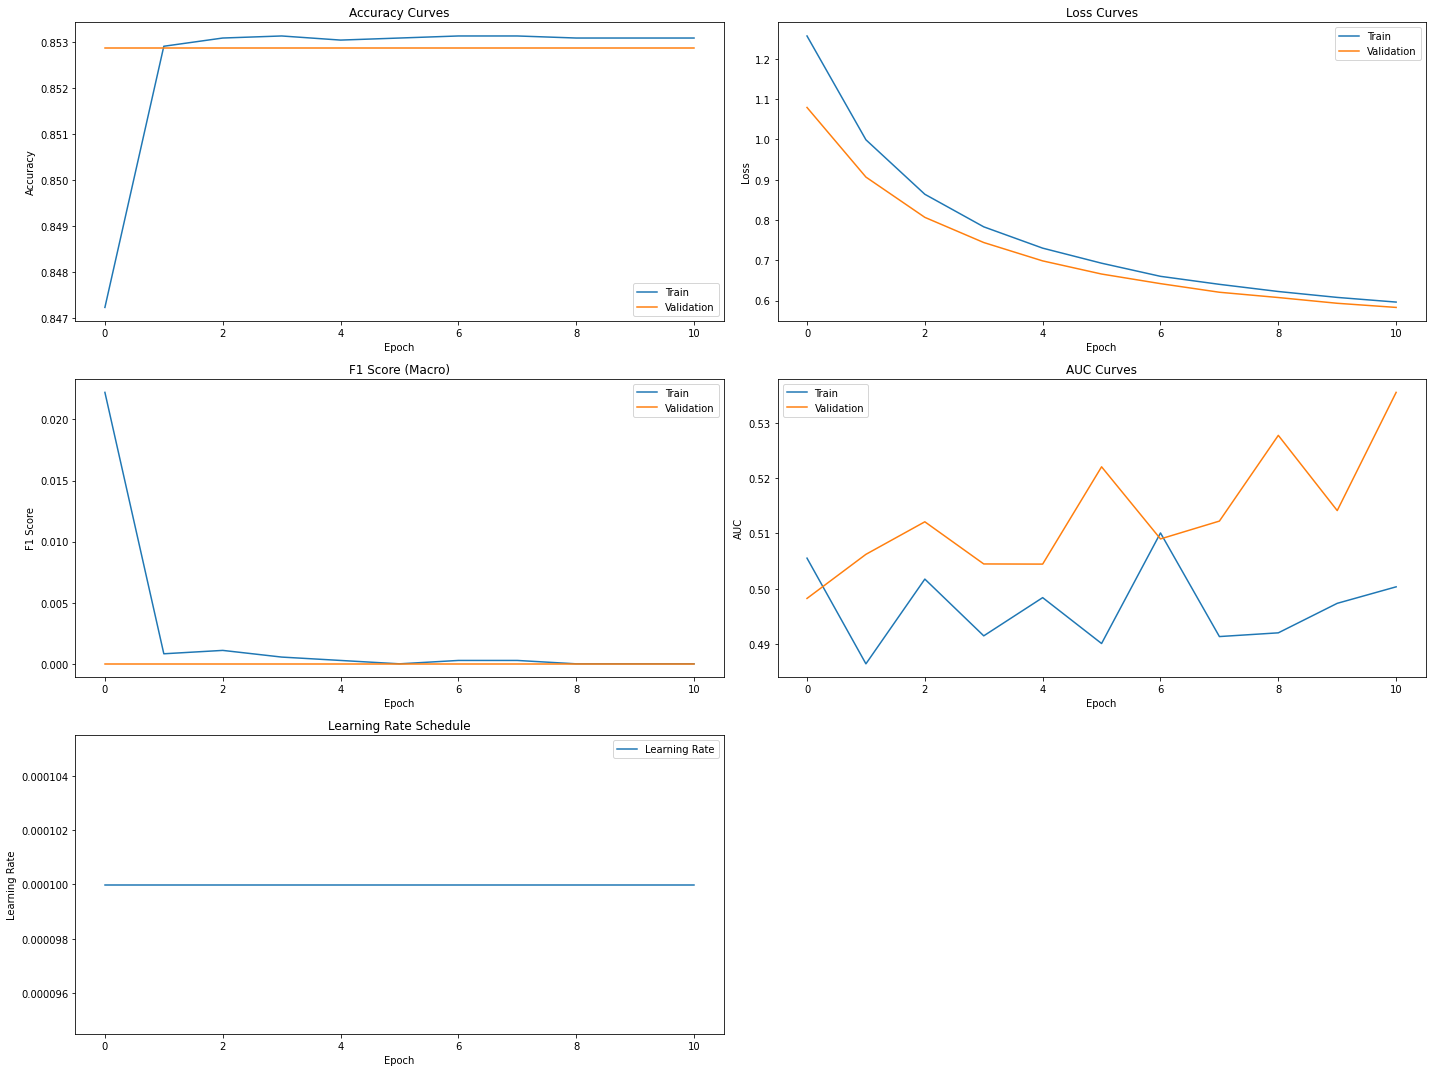

1/1 [==============================] - 0s 81ms/step

Classification Report:
              precision    recall  f1-score   support

           N     0.0000    0.0000    0.0000       228
           D     0.0000    0.0000    0.0000       226
           G     0.0000    0.0000    0.0000        44
           C     0.0000    0.0000    0.0000        39
           A     0.0000    0.0000    0.0000        32
           H     0.0000    0.0000    0.0000        19
           M     0.0000    0.0000    0.0000        36
           O     0.0000    0.0000    0.0000       200

   micro avg     0.0000    0.0000    0.0000       824
   macro avg     0.0000    0.0000    0.0000       824
weighted avg     0.0000    0.0000    0.0000       824
 samples avg     0.0000    0.0000    0.0000       824



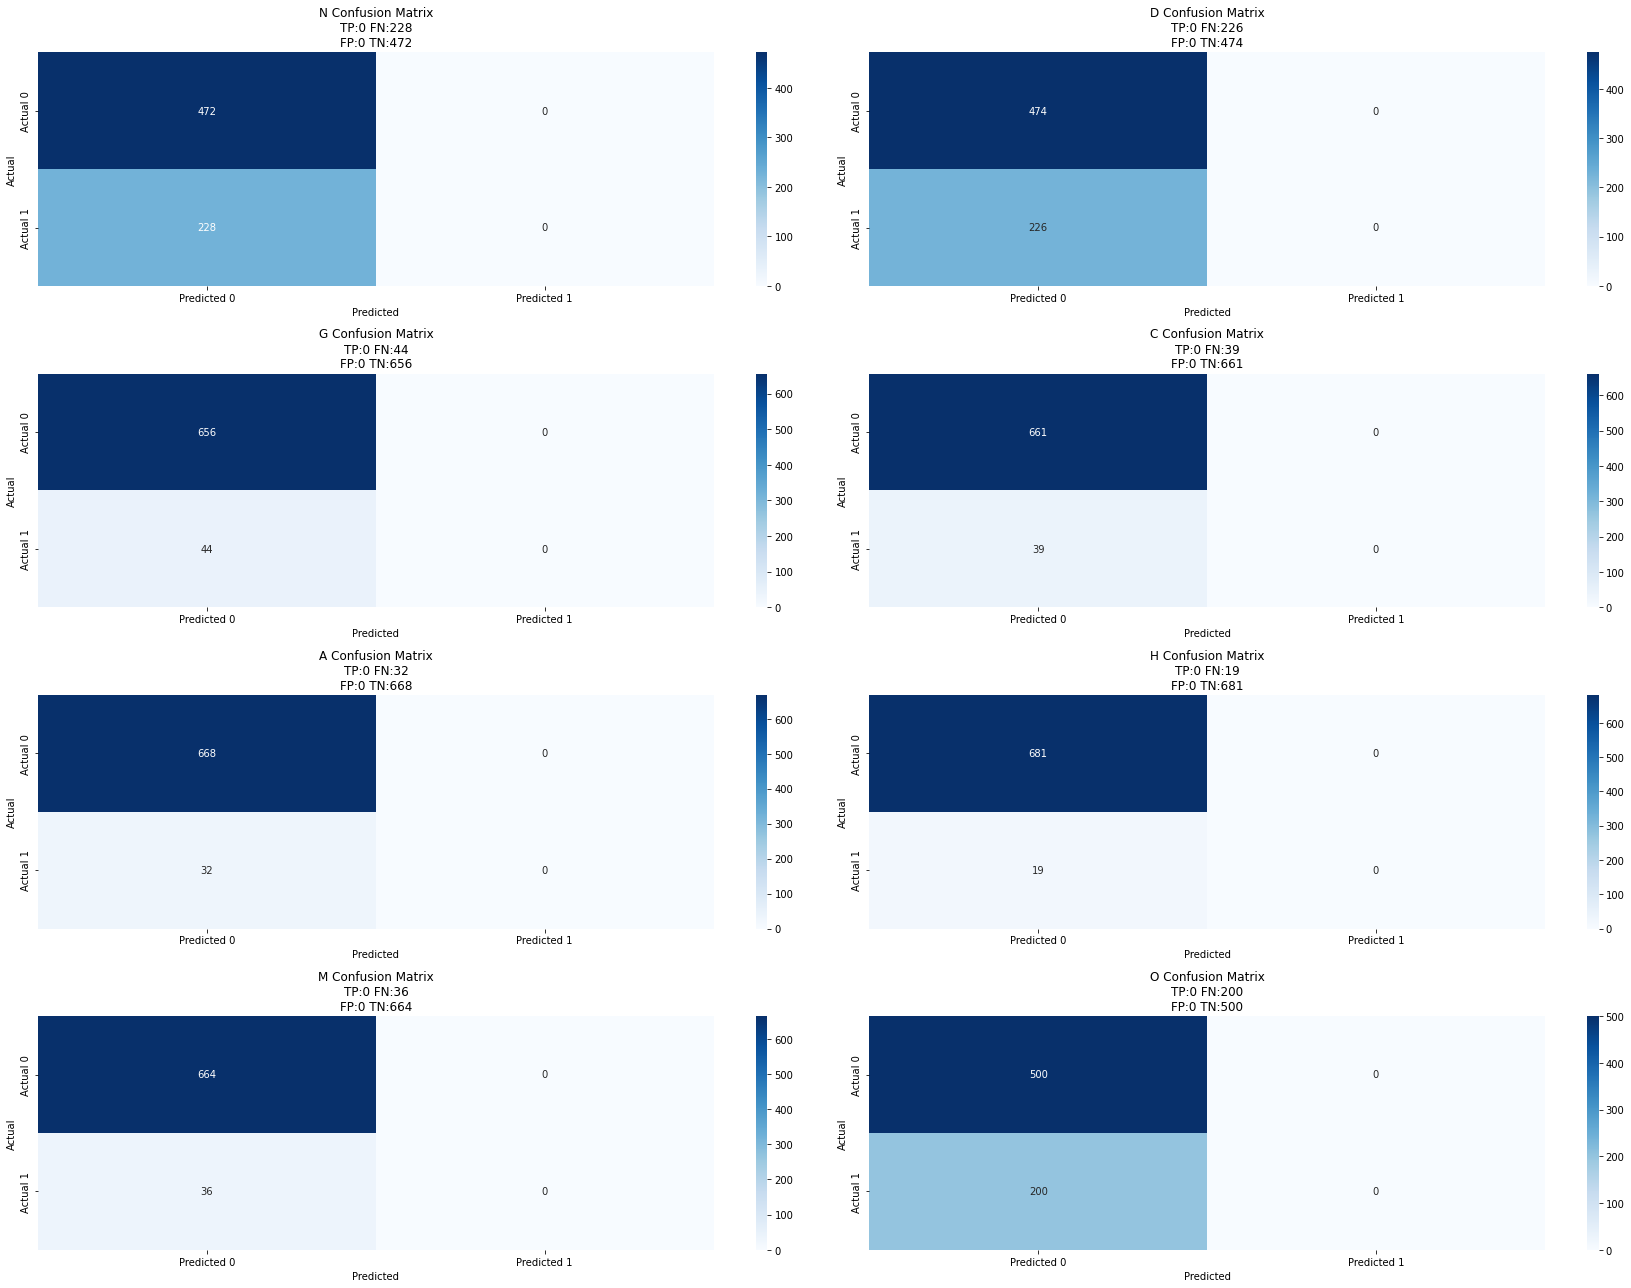


Micro Averages:
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000

Macro Averages:
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, utils
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 配置参数
DATA_DIR = "OIA-ODIR/Training Set/Images"
CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
SAVE_DIR = "saved_models_final"
os.makedirs(SAVE_DIR, exist_ok=True)

# 清理自定义对象注册
tf.keras.utils.get_custom_objects().clear()

# 注册自定义损失函数
@utils.register_keras_serializable(package='CustomObjects')
class WeightedBCE(tf.keras.losses.Loss):
    def __init__(self, class_weights, name="weighted_bce"):
        super().__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        
    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weights = tf.reduce_sum(self.class_weights * y_true, axis=-1)
        return tf.reduce_mean(bce * weights)
    
    def get_config(self):
        return {'class_weights': self.class_weights.numpy().tolist()}

# 增强型数据预处理
class FundusDataLoader:
    def __init__(self, augment=True):
        self.augment = augment
        self.base_process = tf.keras.Sequential([
            layers.Resizing(*IMAGE_SIZE),
            layers.Rescaling(1./255)
        ])
        self.augmenter = tf.keras.Sequential([
            layers.RandomRotation(0.15),
            layers.RandomContrast(0.15),
            layers.RandomBrightness(0.15),
            layers.RandomFlip(mode='horizontal')
        ]) if augment else None
    
    def load_and_preprocess(self, img_path):
        try:
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = self.base_process(img)
            if self.augmenter:
                img = self.augmenter(img)
            return img
        except Exception as e:
            print(f"Error loading image: {img_path}")
            return tf.zeros((*IMAGE_SIZE, 3), dtype=tf.float32)

# 数据管道
def create_datasets(df):
    class_counts = df[CLASS_NAMES].sum(axis=0) + 1e-6
    class_weights = (1 / class_counts) * (class_counts.sum() / len(CLASS_NAMES))
    
    df['left_path'] = df['Left-Fundus'].apply(
        lambda x: os.path.join(DATA_DIR, x)
    )
    df['right_path'] = df['Right-Fundus'].apply(
        lambda x: os.path.join(DATA_DIR, x)
    )
    
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df[CLASS_NAMES].values.argmax(axis=1),
        random_state=42
    )
    
    train_loader = FundusDataLoader(augment=True)
    train_ds = tf.data.Dataset.from_tensor_slices((
        train_df[['left_path', 'right_path']].values,
        train_df[CLASS_NAMES].values.astype(np.float32)
    )).map(
        lambda paths, y: (
            (train_loader.load_and_preprocess(paths[0]), 
             train_loader.load_and_preprocess(paths[1])), y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    ) \
     .shuffle(1000) \
     .batch(BATCH_SIZE) \
     .prefetch(tf.data.AUTOTUNE)
    
    val_loader = FundusDataLoader(augment=False)
    val_ds = tf.data.Dataset.from_tensor_slices((
        val_df[['left_path', 'right_path']].values,
        val_df[CLASS_NAMES].values.astype(np.float32)
    )).map(
        lambda paths, y: (
            (val_loader.load_and_preprocess(paths[0]), 
             val_loader.load_and_preprocess(paths[1])), y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    ) \
     .batch(BATCH_SIZE) \
     .prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, class_weights

# 双流网络模型
def build_siamese_model():
    base = tf.keras.applications.EfficientNetB3(
        include_top=False,
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = False
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3), name='left_eye')
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3), name='right_eye')
    
    left_features = base(left_input)
    right_features = base(right_input)
    
    diff = layers.Subtract()([left_features, right_features])
    att = layers.Attention()([left_features, right_features])
    merged = layers.Concatenate()([diff, att])
    
    # 修复：使用正确的GlobalAveragePooling2D层
    x = layers.GlobalAveragePooling2D()(merged)
    x = layers.Dense(512, activation='swish', 
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(256, activation='swish')(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 训练流程
def train_and_evaluate():
    df = pd.read_excel(CSV_PATH)
    train_ds, val_ds, class_weights = create_datasets(df)
    
    model = build_siamese_model()
    
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=WeightedBCE(class_weights=class_weights),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tfa.metrics.F1Score(
                num_classes=len(CLASS_NAMES),
                average='macro',
                threshold=0.5,
                name='f1_macro'
            ),
            tf.keras.metrics.AUC(name='auc', multi_label=True)
        ]
    )
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_f1_macro',
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_f1_macro',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(os.path.join(SAVE_DIR, 'training_log.csv'))
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=callbacks,
        verbose=2
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    
    plot_training_curves(history)
    evaluate_model(model, val_ds)
    
    return model, history

# 训练曲线可视化
def plot_training_curves(history):
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.plot(history.history['f1_macro'], label='Train')
    plt.plot(history.history['val_f1_macro'], label='Validation')
    plt.title('F1 Score (Macro)')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.subplot(3, 2, 4)
    plt.plot(history.history['auc'], label='Train')
    plt.plot(history.history['val_auc'], label='Validation')
    plt.title('AUC Curves')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.subplot(3, 2, 5)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_curves.png'))
    plt.show()

# 模型评估
def evaluate_model(model, val_ds):
    y_true = []
    y_pred = []
    for batch in val_ds:
        _, y_batch = batch
        y_true.append(y_batch.numpy())
        y_pred.append(model.predict(batch[0]) > 0.5)
    
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0
    ))
    
    cm = multilabel_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(24, 18))
    for i, (cls, matrix) in enumerate(zip(CLASS_NAMES, cm)):
        plt.subplot(4, 2, i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Predicted 0', 'Predicted 1'],
                   yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'{cls} Confusion Matrix\nTP:{matrix[1,1]} FN:{matrix[1,0]}\nFP:{matrix[0,1]} TN:{matrix[0,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrices.png'))
    plt.show()
    
    micro_pre = precision_score(y_true, y_pred, average='micro')
    micro_rec = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    
    macro_pre = precision_score(y_true, y_pred, average='macro')
    macro_rec = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"\nMicro Averages:")
    print(f"Precision: {micro_pre:.4f} | Recall: {micro_rec:.4f} | F1: {micro_f1:.4f}")
    print(f"\nMacro Averages:")
    print(f"Precision: {macro_pre:.4f} | Recall: {macro_rec:.4f} | F1: {macro_f1:.4f}")

if __name__ == "__main__":
    model, history = train_and_evaluate()